# Ensemble Hyperparams

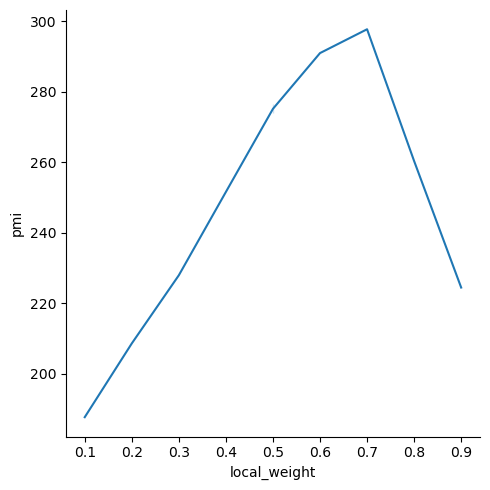

In [28]:
from glob import glob
import json
import seaborn as sns
from pathlib import Path
import json
import numpy as np
import re
import pandas as pd
DATASET='20NewsGroup'
RUN_DIR = 'evaluation_reduced'

FN_MATCHER = r'local-(?P<local>[0-9]\.[0-9])-global-(?P<global>[0-9]\.[0-9])-rho-(?P<rho>[0-9]\.[0-9]).json'
RESULTS_DIR = Path('./results') / DATASET / 'evaluations' / RUN_DIR
PLOTS_OUTPUT_DIR = RESULTS_DIR / 'plots'
PLOTS_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
def parse_ensemble_results(dir: Path):
    files = list(dir.glob('local-*.json'))
    res = np.zeros((len(files), 6))
    for i, filename in enumerate(files):
        matches = re.search(FN_MATCHER, str(filename))
        f = open(filename, 'r')
        data = json.load(f)
        res[i][0] = float(matches.group('global'))
        res[i][1] = float(matches.group('local'))
        res[i][2] = float(matches.group('rho'))
        res[i][3] = float(data['scores']['pmi'])
        res[i][4] = float(data['scores']['npmi'])
        res[i][5] = float(data['scores']['distinctiveness'])
    df = pd.DataFrame(
        res,
        columns=[
            'global_weight',
            'local_weight',
            'rho',
            "pmi",
            'npmi',
            'distinctiveness'
        ]
    )
    return df
df = parse_ensemble_results(RESULTS_DIR)
sns.relplot(
    df,
    kind='line',
    x='local_weight',
    y='pmi',
    hue=''
)

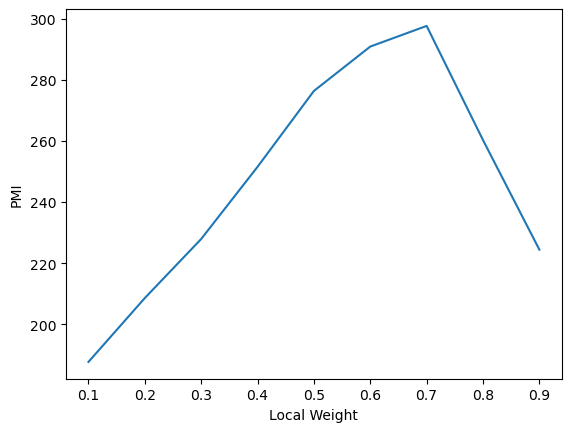

In [26]:
df[df.rho==0.5].sort_values('local_weight').plot.line('local_weight', y='pmi', legend=None)
plt.ylabel('PMI')
plt.xlabel('Local Weight')
plt.savefig(PLOTS_OUTPUT_DIR/'weight-pmi.png')

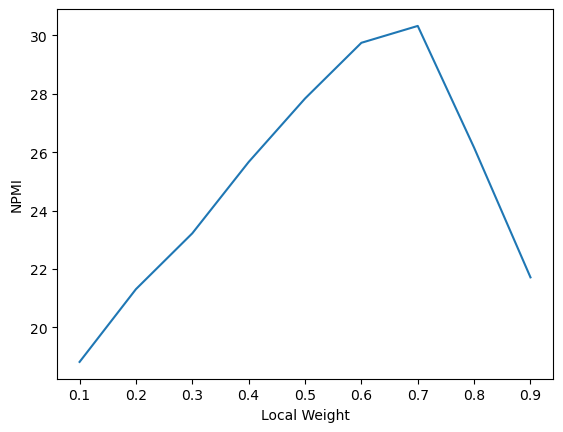

In [27]:
df[df.rho == 0.5].sort_values('local_weight').plot.line('local_weight',
                                                        y='npmi',
                                                        legend=None)
plt.ylabel('NPMI')
plt.xlabel('Local Weight')
plt.savefig(PLOTS_OUTPUT_DIR / 'weight-npmi.png')


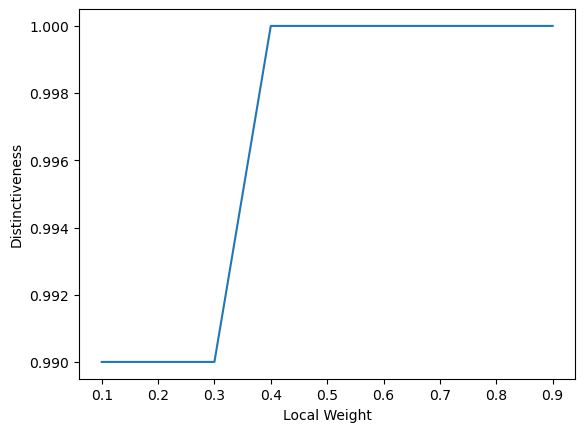

In [28]:
df[df.rho == 0.5].sort_values('local_weight').plot.line('local_weight',
                                                        y='distinctiveness',
                                                        legend=None)
plt.ylabel('Distinctiveness')
plt.xlabel('Local Weight')
plt.savefig(PLOTS_OUTPUT_DIR / 'weight-distinctiveness.png')

# Evaluation By methods

In [23]:
import os
import json
import pandas as pd

def result_json2dataset(datasets):
    from os.path import join as j
    results = {
        "dataset": [],
        "method": [],
        "metric": [],
        "score": [],
    }

    for dataset in datasets:
        evaluation_root = f"./results/{dataset}/evaluations/"
        methods = [
            ('CaTE', j(evaluation_root, 'cate.json')),
            ('Finetuned BERT', j(evaluation_root, 'finetuned-bert.json')),
            ('Pretrained BERT', j(evaluation_root, 'pretrained-bert.json')),
            ('SeededLDA', j(evaluation_root, 'seeded_lda.json')),
            (
                'EnsembleTM',
                j(evaluation_root, 'ensemble',
                  'local-0.5-global-0.5-rho-0.5.json'),
            ),
            (
                'EnsembleTM (Rank Reduced)',
                j(evaluation_root, 'evaluation_reduced',
                  'local-0.5-global-0.5-rho-0.5.json'),
            ),
        ]
        for method, file in methods:
            try:
                f = open(file, 'r')
                result = json.load(f)
                f.close()
                if len(result.keys()) == 1:
                    key = list(result.keys())[0]
                    result = result[key]

                for metric in metrics:
                    results['dataset'].append(dataset)
                    results['method'].append(method)
                    results['metric'].append(metric)
                    results['score'].append(result[metric])
            except FileNotFoundError:
                for metric in metrics:
                    results['dataset'].append(dataset)
                    results['method'].append(method)
                    results['metric'].append(metric)
                    results['score'].append(None)
    df = pd.DataFrame(results)
    return df
results = result_json2dataset(['20NewsGroup', 'scidoc', 'yelp'])
results

,dataset,method,metric,score
0,20NewsGroup,CaTE,pmi,196.448957
1,20NewsGroup,CaTE,npmi,17.768505
2,20NewsGroup,CaTE,distinctiveness,1.000000
3,20NewsGroup,Finetuned BERT,pmi,170.228088
4,20NewsGroup,Finetuned BERT,npmi,16.887926
5,20NewsGroup,Finetuned BERT,distinctiveness,0.980000
6,20NewsGroup,Pretrained BERT,pmi,195.671083
7,20NewsGroup,Pretrained BERT,npmi,17.273419
8,20NewsGroup,Pretrained BERT,distinctiveness,0.960000
9,20NewsGroup,SeededLDA,pmi,261.348411


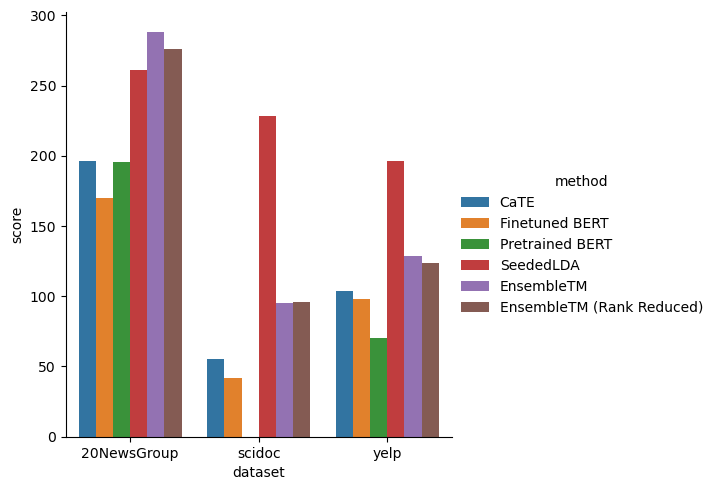

In [26]:
import seaborn as sns
sns.catplot(results[results['metric']=='pmi'], kind='bar', x='dataset', y='score', hue='method')

# In Vocab Vs Out Vocab

In [26]:
import os
from scripts.utils.io import load_seed
import re
import pandas as pd
import seaborn as sns
MATCHER = r'(?P<seed>[a-z_]+):(?P<pmi>[0-9.]*)'
def txt_output2dataframe(*datasets):
    # load seeds
    data = {
        "Dataset": [],
        "Type": [],
        "PMI": []
    }
    for dataset in datasets:

        dataset_result = {
            "In vocabulary Average": 0,
            "Out Vocabulary Average": 0,
            "Overall Average": 0,
        }
        seed_path = os.path.join('./data', dataset, 'seeds.json')
        result_path = os.path.join('./results/', dataset, 'evaluations', 'ensemble_pmi.txt')
        in_vocab, out_vocab = load_seed(seed_path, False)
        f = open(result_path, 'r')
        lines = f.readlines()
        f.close()
        pmis = ensemble_pmi2dict(lines)
        out_vocab_pmi = sum(pmis[word] for word in out_vocab) / len(in_vocab)
        in_vocab_pmi = sum(pmis[word] for word in in_vocab) / len(out_vocab)
        dataset_result['In vocabulary Average'] = in_vocab_pmi
        dataset_result['Out Vocabulary Average'] = out_vocab_pmi
        dataset_result['Overall Average'] = (in_vocab_pmi + out_vocab_pmi) / len(pmis)
        for key, value in dataset_result.items():
            data['Dataset'].append(dataset)
            data['Type'].append(key)
            data['PMI'].append(value)
    print(data)
    return pd.DataFrame(data)

def ensemble_pmi2dict(lines):
    res = {}
    for line in lines:
        match = re.match(MATCHER, line)
        match = match.groupdict()
        seed = match['seed']
        pmi = match['pmi']
        res[seed] = float(pmi)

    return res
df = txt_output2dataframe('scidoc', '20NewsGroup', 'yelp')

{'Dataset': ['scidoc', 'scidoc', 'scidoc', '20NewsGroup', '20NewsGroup', '20NewsGroup', 'yelp', 'yelp', 'yelp'], 'Type': ['In vocabulary Average', 'Out Vocabulary Average', 'Overall Average', 'In vocabulary Average', 'Out Vocabulary Average', 'Overall Average', 'In vocabulary Average', 'Out Vocabulary Average', 'Overall Average'], 'PMI': [206.22535668195593, 2.0447822840852665, 18.933648996912837, 377.451844617215, 198.5672248213353, 57.601906943855035, 217.31792971154928, 40.100569581403036, 25.741849929295235]}


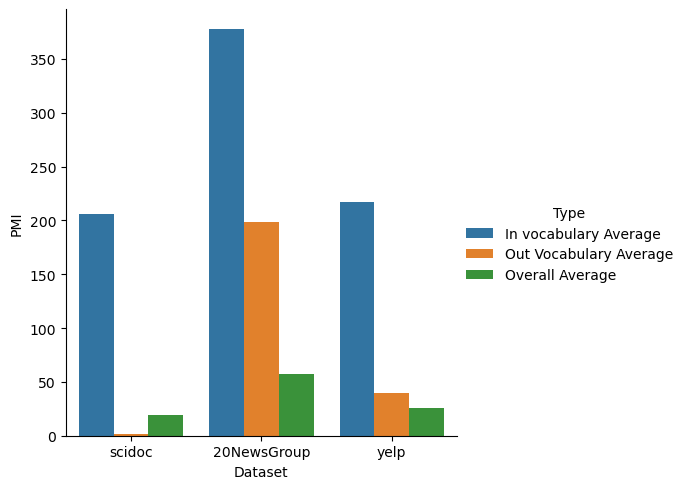

In [27]:
sns.catplot(df,
            kind='bar',
            x='Dataset',
            y='PMI',
            hue='Type')
